## New APIs for end-to-end Speech - Unit - Speech conversion

This notebook demonstrates the end-to-end Speech -> Unit -> Speech conversion loop using the new set of APIs in stopes.speech, inspired by traditional NLP tokenization process. Specifically, a speech tokenizer consits of three components:

- *A speech encoder*: For example wave2vec, HuBERT, XLS-R, etc. The encoder will load the wave form features of the input audio and transform into the embedding vectors.

- *A unit*: This component converts each vectors into one of the fixed units from a "vocabulary". An embedding vector can itself be a unit. In practice, however, we would quantize the embedding space using e.g. K-Means, where each vector is converted to its nearest centroid. In this case, each centroid is a unit.

- *A vocoder*: The vocoder loads discrete units and reconstructs the wave forms using a matching pretrained model as the speech encoder.

Quick runthrough:

In [10]:
%%capture --no-stderr

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import torchaudio
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)

import stopes.hub as hub

# the following also works:
# from stopes.speech import speech_tokenizer


# load data in wave form
libri_dataset = torchaudio.datasets.LibriLightLimited(".", download="True")
libri_data, sample_rate, _, _, _, _ = libri_dataset[0]

# Load a pretrained model from a speech tokenizers hub via AutoSpeech
tokenizer = hub.speech_tokenizer("en_xlsr_lyr35")

# alternatively: tokenizer = speech_tokenizer("en_xlsr_lyr35")

# encode the audio into discrete units
units = tokenizer.encode(libri_data)

# decoded back to wave form
decoded_libri_data = tokenizer.decode(units)

/private/home/tuantran/.conda/envs/seamless_bootcamp_310/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MiniBatchKMeans from version 0.24.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [11]:
units

tensor([[685, 627, 255, 235, 191, 255, 998,  10, 151, 738, 558, 763, 763, 621,
         406,  46, 639, 317, 142, 142, 269, 570, 593, 593, 233, 789, 401, 423,
         960, 168,  76, 933, 560, 479,  82,  88,  88, 610, 610, 610, 140, 866,
         671, 568, 515, 384,  15, 609, 262, 308, 540, 540, 981, 722, 973, 954,
         257, 257, 384, 384, 609, 262, 415, 916, 247, 762, 659, 146, 516, 669,
         478,  44, 816, 132, 176,  92, 317, 142, 369, 273, 493, 123, 533, 322,
         322, 407, 546, 444, 275, 689, 338, 338, 444, 162,  86, 414, 787, 425,
         990, 820, 440, 891, 891, 940, 487, 448, 749, 817, 644, 817, 774, 629,
         680, 231,  66,  66, 380, 223, 600, 164, 615, 615, 933, 128, 836, 975,
         251, 375, 634,  33,  33, 649, 649, 233, 298, 475,  39, 517, 881, 923,
         328, 919, 277, 881, 415, 199, 965, 911, 780, 780, 121, 506, 831, 539,
         962, 905,  94, 386, 715, 608, 608, 227, 608, 343, 808, 200, 200, 237,
         822, 666, 437, 806,  53, 806, 153, 153, 838

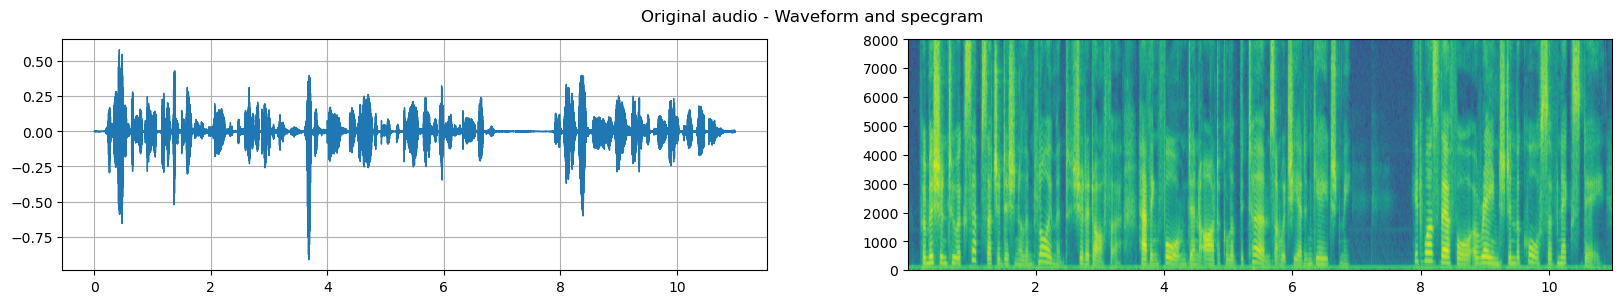

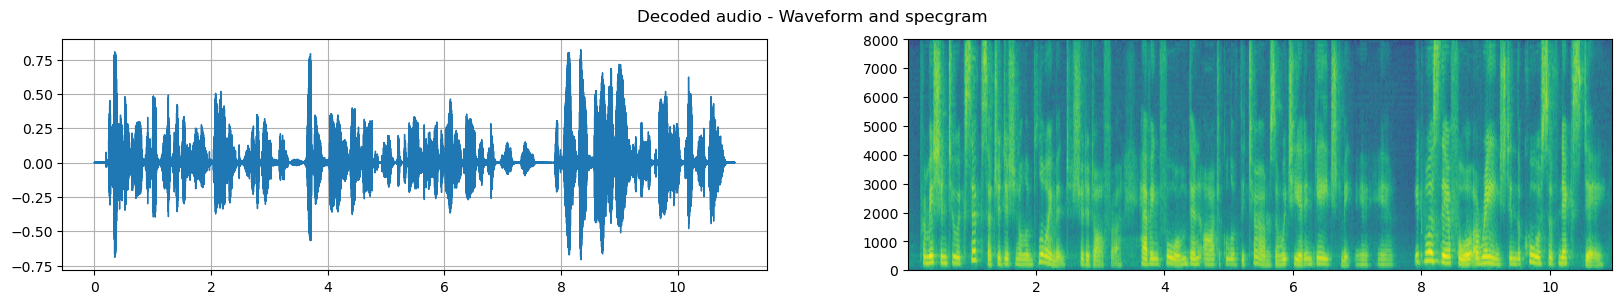

In [15]:
# Compare the original and decoded audio

from stopes.speech.examples.notebook import plot_waveform_and_specgram, play_audio

plot_waveform_and_specgram(libri_data.squeeze(), sample_rate, title="Original audio")
plot_waveform_and_specgram(decoded_libri_data.squeeze(), sample_rate, title="Decoded audio")

### Customized configuration

It is also possible to customize your own pipeline of speech tokenization by providing your own configuration. This is done using the sampe API `AutoSpeech.speech_tokenizer()` with inline arguments for each component:

`AutoSpeech.tokenizer` allows it to override any of the configuration via inline arguments, for example:

In [21]:
vocoder = {
    "checkpoint": "my_checkpoint",
    "config_path": "my_config.json"
}

tokenizer = AutoSpeech.speech_tokenizer(vocoder=vocoder)

### Providing your own SpeechTokenizer

By default, the speech tokenizer uses Xlsr as pretrained model based on which all the three components are configured. `stopes.speech` allows using other extended encoders (HuBERT, Encodec, etc.) with similar Hydra-style: By declaring your tokenizer in `_target_` section of the configuration. Each tokenizer should inherit `stopes.speech.tokenizers.SpeechTokenizer` and implement at minimum the three functions:

- `extract_features()`: This dictates how the speech_encoder should be run to convert wave form to vectors.
- `to_unit()`: How to construct the discrete units from the encoder output.
- `decode()`: How to decode units back to wave form


(Note that the `encode()` is already implemented as the chain of `extract_features()` and `to_unit()`. You can override this function in some edge cases, but most of the time, the implementation should cover your need).

The implementation should ensure that the combination of different components work well. To validate the user input regarding this combination, you can override the function `validate_model_config()`

In [39]:
from stopes.speech.tokenizers import SpeechTokenizer
import torch


class MyTokenizer(SpeechTokenizer):
    """Simple customized speech tokenizer which does nothing but returns all input tensor as output"""
    #
    # If your configuration looks different, provide your own
    # `config` properties, i.e:
    #
    # config: MyConfigDataClass
    #
    def validate_model_config(self, *inputs, **kwargs):
        # BaseSpeechTokenizer already loads the model checkpoint
        # into self.model
        model_cls = type(self.model).__name__
        assert (
            "Hubert" in model_cls,
            f"Invalid model declaration (expected a HuBERT model, get {model_cls})",
        )

    def to_unit(self, x: torch.Tensor) -> torch.Tensor:
        return x

    def extract_features(self, x: torch.Tensor) -> torch.Tensor:
        return x

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        return x

    def decode(self, x: torch.Tensor) -> torch.Tensor:
        return x


<>:17: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:17: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/tmp/ipykernel_2159729/3199866378.py:17: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (


We will prepapre one configuration using [Hongyu]'s HuBERT model for the Speech Matrix task:

In [35]:
import yaml

# Prepare the configuration and write to a local YAML file
my_config = {
    "_target_": "__main__.MyTokenizer",
    "speech_encoder": {
        "checkpoint": "",
        "feature_layer": 11,
    },
    "units": "",
    "vocoder": {
        "checkpoint": "my_checkpoint",
        "config_path": "my_config.json"
    }
}

with open("my_config.yaml", "w") as fout:
    yaml.dump(my_config, fout)


Now we are ready to run the new pipeline:

In [38]:
my_tokenizer = AutoSpeech.speech_tokenizer("./my_config.yaml")

new_units = my_tokenizer.encode(libri_data)
new_encoded_libri_data = my_tokenizer.decode(new_units)

assert (torch.equal(new_units, new_encoded_libri_data))